## Table of Contents

1. [Introduction](#intro)
2. [Data Loading & Cleaning](#data-loading)
    - [Load & Inspect Movies Dataset](#movies-loading)
    - [Clean Movies Dataset](#movies-cleaning)
    - [Load & Inspect Reviews Dataset](#reviews-loading)
    - [Clean Reviews Dataset](#reviews-cleaning)
    - [Load & Inspect Metadata Dataset](#metadata-loading)
    - [Clean Metadata Dataset](#metadata-cleaning)
    - [Load & Inspect IMDb Ratings Dataset](#imdb-loading)
3. [Joining Dataframes](#joining-dataframes)
4. [Exploring Reviews per Movie](#reviews-per-movie)
5. [Exploratory Data Analysis](#eda)

# Introduction

The overarching objective of this analysis is to **predict a movie's IMDb star rating using both review text and various metadata features such as genre, actors, director, budget, and revenue**. This notebook is specifically devoted to the tasks of data cleaning and data wrangling, preparing our main datasets for analysis.

## Data Sources

We've faced challenges in finding a single dataset that encapsulates both extensive review texts and comprehensive metadata for a broad range of movies. To overcome this hurdle, we're integrating three datasets from different sources. A unique IMDb ID common to all these datasets enables this integration.

### Dataset 1: MovieLens Review Data
This dataset is from MovieLens and consists of two separate files: 
- One file contains IMDb review texts and basic movie information like title, director, and actors. It includes approximately 52,000 unique movies.
- The other file maps these reviews to corresponding IMDb IDs. It comprises around 84,000 unique movies.

**Note**: We won't be using the MovieLens user ratings in our analysis, as we're focused on predicting IMDb ratings.

[Dataset Link](https://grouplens.org/datasets/movielens/tag-genome-2021/)

### Dataset 2: Spoilers Review Data
Our second dataset serves to supplement the review text data from MovieLens. While it has fewer unique movies (~1500), it broadens our review text corpus. Crucially, all of these 1500 movies also appear in the MovieLens dataset, enabling seamless integration.

[Dataset Link](https://www.kaggle.com/datasets/rmisra/imdb-spoiler-dataset)

### Dataset 3: TMDB Metadata
Our final dataset comes from TMDB, and contains metadata for 100,000 movies across 27 different features, such as budget, director, and production company. After initial cleaning in a separate notebook, it will be joined with the MovieLens review data to constitute our final dataframe.

[Dataset Link](https://www.kaggle.com/datasets/kakarlaramcharan/tmdb-data-0920)

Upon completion, our final dataframe will contain a single row for each movie, encapsulating all the relevant metadata and review text.

The final goal of our analysis will be to **predict the IMDb star rating of a movie based on the text of reviews along with other "metadata" features of the movie such as genre, actors, director, budget, revenue, etc.** For this notebook, we will be doing data cleaning and wrangling of our main datasets. 

We will be using several different datasets throughout our analysis. It was challenging to find a dataset that contained both sufficient review text for a large enough set of movies in addition to metadata about those movies. Thus, we will be joining together 3 datasets from different sources in order to create a final dataset that we can use for this analysis. 

What makes this possible is the common IMDb ID across all three datasets.

#### Dataset 1 - MovieLens Review Data
Movies and Review Text - This dataset (2 files) was taken from MovieLens and contains the IMDb review text, along with basic features such as title, director, actor, and the average rating given by MovieLens users. We will not be using this rating, since our goal is to predict IMDb rating, and our reivew text comes from IMDb. 
- The review dataset contains ~52k unique movies, and the movies dataset contains ~84k unique movies 
- Review text dataset contains just the user review text, and an `item_id` per movie. 
- The other contains some movie data and corresponding `item_id` along with `imdb_id`. The main purpose of this dataset is to be able to assign an `imdb_id` to each row of user review text that wek have.
- Dataset link: https://grouplens.org/datasets/movielens/tag-genome-2021/

#### Dataset 2 - Spoilers Review Data 
We will supplement our user review text with an additional dataset that also contains user review text and basic movie information. Vey similar structure to the MovieLens dataset. However, while this dataset contains a large number of user reivews, it has only ~1500 unique movies. Luckily, the 1500 movies here are contained within the MovieLens dataset, so we will use these additional reviews to supplement our corpus of user review text. 
- Contains `imdb_id` that can be easily joined to the MovieLens reviews
- Dataset link: https://www.kaggle.com/datasets/rmisra/imdb-spoiler-dataset

#### Dataset 3 - TMDB Metadata 
Movie Metadata - This dataset was taken from TMDB and contains 100k movies and 27 features of movie metadata, such as budget, director, actor, production company, budget, revenue, original language, etc. We will be using as many of these features as we can. This dataset contains most of the movies from our MovieLens dataset. Thus, once we have cleaned this dataset (done in another notebook), we will join it to our MovieLens reviews data to get our final dataframe.
- This dataset also includes the `imdb_id`, allowing us to easily filter it to our desired set of IDs 
- This dataset will be cleaned in a separate notebook, and the finished product used in this notebook 
- Dataset link: https://www.kaggle.com/datasets/kakarlaramcharan/tmdb-data-0920

Ultimately, for our final dataframe, the goal is to have just one row per movie containing all metadata and review text.

## Data Loading <a name="data-loading"></a>

In [1]:
# Importing libraries we will likely need for EDA
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# To read dataset in JSON format
import json

#### Load & Inspect Movies Dataset <a name="movies-loading"></a>

This is our first dataset from the MovieLens pair of datasets, and contains basic movie information. The main feature of interest here is the IMDb ID, which we need in order to join multiple dataset together.

In [2]:
# Load movies JSON file

movies_df = pd.read_json('data/movie_dataset_public_final/raw/metadata_updated.json', lines=True)

In [3]:
# Inspect the dataframe

movies_df.head()

,title,directedBy,starring,avgRating,imdbId,item_id
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney,...",3.89146,114709,1
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams,...",3.26605,113497,2
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sop...",3.17146,113228,3
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Housto...",2.86824,114885,4
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimb...",3.07620,113041,5


After looking up some of the `imdbId`s on IMDB, we can see they are missing "tt" and potentially "0" before the number in the column. For example, the IMDb URL for Toy Story is https://www.imdb.com/title/tt0114709/, so the true IMDb ID is tt0114709. However, in the dataset it's stored as '11709'. We'll need to take a closer look at this column and decide how to make changes. 

If we want to get information on additional features about movies from other datasets, we will need to join this dataset on the true IMDb ID, so we'll need to transform our IDs here to make that possible. 

In [4]:
# Check the shape and dtypes

movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84661 entries, 0 to 84660
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       84661 non-null  object 
 1   directedBy  84661 non-null  object 
 2   starring    84661 non-null  object 
 3   avgRating   84661 non-null  float64
 4   imdbId      84661 non-null  int64  
 5   item_id     84661 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 3.9+ MB


We see that `imdbId` is stored as an integer. In order to figure out how we need to change each of the IDs, let's look at a sample of the unique values. We can convert the column to a string, then save and sort the unique values.

In [5]:
# Convert to string and get unique values 

id_values = movies_df['imdbId'].astype(str).unique()
sorted_id_values = sorted(id_values)

print(sorted_id_values[:50])

['1', '10', '100004', '1000095', '100014', '100024', '100029', '10003008', '100031', '100033', '100034', '100038', '10003978', '10004368', '100045', '100046', '100047', '100048', '100049', '10004944', '100050', '100052', '100053', '100054', '100056', '100057', '100058', '10006006', '10006122', '100063', '100065', '100070', '100071', '1000764', '1000768', '1000769', '1000771', '1000774', '1000775', '1000786', '100079', '100087', '10008784', '100089', '10009030', '10009148', '100093', '10009434', '100095', '100097']


Let's examine the movie that has `imdbId` of 1:

In [6]:
# Filter for imdbId of 1 

filtered_row = movies_df[movies_df['imdbId'] == 1]
print(filtered_row)

                   title             directedBy    starring  avgRating  \
51108  Carmencita (1894)  William K.L. Dickson   Carmencita    2.34375   

       imdbId  item_id  
51108       1   172063  


If we look up this title on IMDb, we can see that the true IMDb ID is tt0000001. We can also see that some IDs have 8 or more characters. Let's double check what the maximum length of our `imdbId` column is. 

In [7]:
max_length = movies_df['imdbId'].astype(str).str.len().max()
print("The maximum number of characters in imdbId is:", max_length)

The maximum number of characters in imdbId is: 8


So, the maximum number of characters in `imdbId` column is 8. We know the true IMDb IDs should have either 7 or 8 characters. So we'll need to make changes as follows:
- For any `imdbId`s with 6 or fewer characters, append 'tt' to front of string, plus enough zeros to bring the total character count to 7 
- For any `imdbId`s with 7 or 8 characters: append 'tt' to front of string 

We'll finish checking out the rest of the data before making any changes.

In [8]:
# Double check for null values

movies_df.isna().sum()

title         0
directedBy    0
starring      0
avgRating     0
imdbId        0
item_id       0
dtype: int64

In [9]:
# Check for duplciate rows

movies_df.duplicated().sum()

0

In [10]:
# Check unique number of movies (by item id)

movies_df['item_id'].nunique()

84661

In [11]:
# Confirm unique IMDb IDs matches unique item IDs

movies_df['imdbId'].nunique()

84661

**Movies Data Inspection Summary**
<br>We've successfully loaded our movies dataset and 
- verified there are no duplicate or null values 
- verified the number of unique movies represented in the dataset, as this will be key to ensuring we have enough data for modelling
- confirmed the datatypes for each column are appropriate, except for `imdbId`, which we will need to change (as mentioned earlier) in order to join with another dataset
- confirmed that the count of `item_id` matches the count of `imdbId`, since we want to join additional datasets on the IMDb ID

**Cleaning Notes:** 
- convert `imdbId` to string/object and append tt0 to all entries

#### Clean Movies Dataset <a name="movies-cleaning"></a>

Our major cleaning task for `movies_df` will be to convert the `imdbId` as discussed above. The best way to do this will be to define a function that appends the appropriate characters based on the string length. Since `imdbId` is currently stored as an integer, we'll first convert to a string, then define our function, and apply the transformation.

In [12]:
# Convert 'imdbId' to string

movies_df['imdbId'] = movies_df['imdbId'].astype(str)

# Define a function 

def transform_imdbId(id_str):
    length = len(id_str)
    
    if length <= 6:
        
        # Append 'tt' and enough zeros to make it 7 characters
        
        return 'tt' + '0' * (7 - length) + id_str
    elif length == 7 or length == 8:
        
        # Append 'tt' to the front
        return 'tt' + id_str

# Apply transform_imdbId function to 'imdbId' column

movies_df['imdbId'] = movies_df['imdbId'].apply(transform_imdbId)

In [13]:
# Check a sample to make sure our transformation worked 

movies_df.sample(10)

,title,directedBy,starring,avgRating,imdbId,item_id
45473,Dobbiamo parlare (2015),Sergio Rubini,"Sergio Rubini,Fabrizio Bentivoglio,Maria Pia C...",3.00000,tt5217644,160658
20600,Crossfire Hurricane (2012),Brett Morgen,"Mick Jagger, Keith Richards, Charlie Watts, Ro...",3.52381,tt2370140,100036
50494,From a House on Willow Street (2017),Alastair Orr,"Sharni Vinson,Carlyn Burchell,Steve John Ward,...",2.37879,tt4961380,170835
30521,Demonic (2015),Will Canon,"Maria Bello,Frank Grillo,Cody Horn,Dustin Mill...",2.61000,tt1841642,129372
1127,"Return of Martin Guerre, The (Retour de Martin...",Daniel Vigne,"Gérard Depardieu, Nathalie Baye, Maurice Barri...",3.88517,tt0084589,1150
33646,Double Wedding (2010),Craig Pryce,"Tia Mowry,Tamera Mowry,Ardon Bess,Robin Brûlé,...",3.16667,tt1586740,135963
4554,"Monkey's Mask, The (2000)",Samantha Lang,"Marton Csokas, Abbie Cornish, Kelly McGillis, ...",2.36957,tt0259442,4648
34281,Spilt Milk (2010),,,4.25000,tt1507351,137242
32347,Variety (1983),Bette Gordon,"Sandy McLeod,Luis Guzmán,Will Patton,Richard D...",3.60000,tt0090251,133293
42398,Spike Island (2012),Mat Whitecross,"Elliott Tittensor,Emilia Clarke,Nico Mirallegr...",3.22222,tt1827579,154178


Great! It looks like our transformation worked! After spot checking a few samples of the transformed `imdbId`s, all of them pull up correctly using the IMDb URL format.

Let's re-name the imdbId column to `imdb_id`.

In [14]:
# Rename imdbId column

movies_df.rename(columns={'imdbId': 'imdb_id'}, inplace=True)

In [15]:
# Sanity check

movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84661 entries, 0 to 84660
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       84661 non-null  object 
 1   directedBy  84661 non-null  object 
 2   starring    84661 non-null  object 
 3   avgRating   84661 non-null  float64
 4   imdb_id     84661 non-null  object 
 5   item_id     84661 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 3.9+ MB


We can go ahead and drop the `avgRating` column since this contains ratings from a website other than IMDb, and we will be using the rating from IMDb. 

In [16]:
# Drop avgRating column 

movies_df = movies_df.drop(['avgRating'], axis=1)

In [17]:
# Sanity check 

movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84661 entries, 0 to 84660
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       84661 non-null  object
 1   directedBy  84661 non-null  object
 2   starring    84661 non-null  object
 3   imdb_id     84661 non-null  object
 4   item_id     84661 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.2+ MB


Now we will extract the release year from the title column and save it as a new column.

In [63]:
# Extract year using regex

movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)')

# Remove the year from the title column

movies_df['title'] = movies_df['title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()

In [64]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84661 entries, 0 to 84660
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       84661 non-null  object
 1   directedBy  84661 non-null  object
 2   starring    84661 non-null  object
 3   imdb_id     84661 non-null  object
 4   item_id     84661 non-null  int64 
 5   year        83994 non-null  object
dtypes: int64(1), object(5)
memory usage: 3.9+ MB


In [65]:
movies_df.head()

,title,directedBy,starring,imdb_id,item_id,year
0,Toy Story,John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney,...",tt0114709,1,1995
1,Jumanji,Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams,...",tt0113497,2,1995
2,Grumpier Old Men,Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sop...",tt0113228,3,1995
3,Waiting to Exhale,Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Housto...",tt0114885,4,1995
4,Father of the Bride Part II,Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimb...",tt0113041,5,1995


We should store the year as an integer datatype.

In [71]:
# Convert to numeric, then to integer

movies_df['year'] = pd.to_numeric(movies_df['year'], errors='coerce').fillna(0).astype(int)

In [72]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84661 entries, 0 to 84660
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       84661 non-null  object
 1   directedBy  84661 non-null  object
 2   starring    84661 non-null  object
 3   imdb_id     84661 non-null  object
 4   item_id     84661 non-null  int64 
 5   year        84661 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.9+ MB


We will need to keep in mind that there are likely some '0' values for year here, since we saw some nulls when we initially extracted them. We will likely have to drop these rows, but we'll determine this later. 

In [73]:
# Save to a json file to preserve lists of actors and directors

movies_df.to_json('data/cleaned_csv/clean_movies_df.json', orient='records', lines=True)

---

#### Load & Inspect Reviews Dataset <a name="reviews-loading"></a>

Now we'll load and inspect our dataset that contains movie reviews. This is another JSON file, so we'll read it in using pd.read_json.

In [19]:
# Load reivews JSON file

reviews_df = pd.read_json('data/movie_dataset_public_final/raw/reviews.json', lines=True)

In [20]:
# Inspect the dataframe

reviews_df.head()

,item_id,txt
0,172063,"one-shot record of a belly dancer; ""Carmencita..."
1,95541,Banging Away..; Thomas Edison and William K.L....
2,7065,unbelievable; I cannot understand how anyone c...
3,3739,I'm still starry-eyed from it; I saw this last...
4,1562,Failed on every Front; Joel Schumacher who did...


In [21]:
# Check the shape and dtypes

reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624608 entries, 0 to 2624607
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   item_id  int64 
 1   txt      object
dtypes: int64(1), object(1)
memory usage: 40.0+ MB


In [22]:
# Check for null values

reviews_df.isna().sum()

item_id    0
txt        0
dtype: int64

In [23]:
# Check for duplicated rows 

reviews_df.duplicated().sum()

4727

In [24]:
print(reviews_df.duplicated().sum()/reviews_df.shape[0]*100,"% of our rows are duplicates")

0.1801030858703471 % of our rows are duplicates


It looks like we do have 4,727 duplicate rows, which is less than 1%. Let's check some of them to see if we can spot a pattern. Since our dataset is not very complex, it's likely these are true duplicates.

In [178]:
# Find duplicate rows based on all columns

duplicate_reviews_df = reviews_df[reviews_df.duplicated(keep=False)]

# Sort by all columns

sorted_duplicate_reviews_df = duplicate_reviews_df.sort_values(by=list(reviews_df.columns))

# Display sorted duplicate rows

sorted_duplicate_reviews_df.head(10)

,item_id,txt
1686988,1,A good start to Pixar's film studio; TOY STORY...
1746360,1,A good start to Pixar's film studio; TOY STORY...
1977040,6,"Michael Mann; Robert DeNiro, Al Pacino... ques..."
2582224,6,"Michael Mann; Robert DeNiro, Al Pacino... ques..."
1979567,6,The Coffee shop scene: Al Pacino holds himself...
1979575,6,The Coffee shop scene: Al Pacino holds himself...
1970895,10,Best of the new Bond movies.; Goldeneye is the...
1970899,10,Best of the new Bond movies.; Goldeneye is the...
1970513,10,One of the Finest of 007's Career!; I am still...
1970521,10,One of the Finest of 007's Career!; I am still...


These do appear to be true duplicates, with identical `item_id` and `txt` fields. Since the duplicates are less than 1% of our total data, we should be able to safely drop these rows.

Let's verify that we have the same large number of unique movie IDs in this dataset, which we can tell by coutning the `item_id`s. 

In [25]:
# Check unique number of movies (by item id)

reviews_df['item_id'].nunique()

52081

**Reviews Data Inspection Summary**
<br>We've successfully loaded our reivews dataset into a dataframe and: 
- confirmed we have no null values
- datatypes are appropriate for each column
- confirmed we have >50k unique movies in our data
- discovered that we have 4,727 duplicate rows (0.18% of total), which can be dropped

**Cleaning Notes**
- drop duplicate rows

#### Clean Reviews Dataset <a name="reviews-cleaning"></a>

This dataset is very simple, so our only cleaning action for now is to drop the duplicate rows and add `imdb_id`.

In [26]:
# Make a copy to store clean data

clean_reviews_df = reviews_df.copy()

In [27]:
# Drop duplicates

clean_reviews_df.drop_duplicates(inplace=True)

In [28]:
# Sanity check

clean_reviews_df.duplicated().sum()

0

Now, let's add an `imdb_id` column to `clean_reviews_df`, based on the corresponding `item_id` from `movies_df`.

In [29]:
# Create a reduced movies_df containing only 'item_id' and 'imdb_id'

movies_df_reduced = movies_df[['item_id', 'imdb_id']]

In [30]:
# Sanity check

movies_df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84661 entries, 0 to 84660
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   item_id  84661 non-null  int64 
 1   imdb_id  84661 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [31]:
# Left join on item_id to add imdb_id column to clean_reviews_df

clean_reviews_df = pd.merge(clean_reviews_df, movies_df_reduced, on='item_id', how='left')

In [32]:
# Sanity check

clean_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2619881 entries, 0 to 2619880
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   item_id  int64 
 1   txt      object
 2   imdb_id  object
dtypes: int64(1), object(2)
memory usage: 60.0+ MB


In [33]:
# Check for nulls

clean_reviews_df.isna().sum()

item_id      0
txt          0
imdb_id    783
dtype: int64

In [34]:
# Drop rows where 'imdb_id' is null since these aren't in our movies_df

clean_reviews_df = clean_reviews_df.dropna(subset=['imdb_id'])

In [35]:
clean_reviews_df.head()

,item_id,txt,imdb_id
0,172063,"one-shot record of a belly dancer; ""Carmencita...",tt0000001
1,95541,Banging Away..; Thomas Edison and William K.L....,tt0000005
2,7065,unbelievable; I cannot understand how anyone c...,tt0004972
3,3739,I'm still starry-eyed from it; I saw this last...,tt0023622
4,1562,Failed on every Front; Joel Schumacher who did...,tt0118688


In [36]:
# Rename columns

clean_reviews_df.rename(columns={'txt': 'review_text'}, inplace=True)

In [37]:
# Save new column order to a list 

reviews_new_column_order = ['item_id', 'imdb_id', 'review_text']

In [38]:
# Reordering the columns

clean_reviews_df = clean_reviews_df.reindex(columns=reviews_new_column_order)

In [39]:
clean_reviews_df.head()

,item_id,imdb_id,review_text
0,172063,tt0000001,"one-shot record of a belly dancer; ""Carmencita..."
1,95541,tt0000005,Banging Away..; Thomas Edison and William K.L....
2,7065,tt0004972,unbelievable; I cannot understand how anyone c...
3,3739,tt0023622,I'm still starry-eyed from it; I saw this last...
4,1562,tt0118688,Failed on every Front; Joel Schumacher who did...


Great, we can now drop the `item_id` column since we have already added `imdb_id`, and the rest of our data will be using `imdb_id`.

In [40]:
# Drop the 'item_id' column

clean_reviews_df = clean_reviews_df.drop('item_id', axis=1)

In [41]:
# Check

clean_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2619098 entries, 0 to 2619880
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   imdb_id      object
 1   review_text  object
dtypes: object(2)
memory usage: 59.9+ MB


Great, we've confirmed that there are no duplicate rows in our new `clean_reviews_df`. We're done with this for now, and we'll save to csv

In [42]:
# Save to json

clean_reviews_df.to_json('data/cleaned_csv/clean_reviews_df.json', orient='records', lines=True)

Let's do a quick check on the number of common movies we have across our cleaned movie and review datasets.

In [43]:
# Get unique 'imdb_id' values from movies_df

unique_imdb_ids_movies = movies_df['imdb_id'].unique()

# Convert unique 'imdb_id' values to series

unique_imdb_ids_movies_series = pd.Series(unique_imdb_ids_movies)

# Check which'imdb_id' values in movies_df are also in clean_reviews_df

matching_unique_imdb_ids = unique_imdb_ids_movies_series[unique_imdb_ids_movies_series.isin(clean_reviews_df['imdb_id'])]

# Count matching unique 'imdb_id's

count_matching_unique_imdb_ids = len(matching_unique_imdb_ids)

print(f"The number of unique 'imdb_id's that match is: {count_matching_unique_imdb_ids}")

The number of unique 'imdb_id's that match is: 52048


In [44]:
# Count the number of unique 'item_id's in movies_df that also appear in reviews_df

matching_item_count = movies_df[movies_df['item_id'].isin(reviews_df['item_id'])]['item_id'].nunique()

print(f"Number of unique 'item_id's in movies_df that match with reviews_df: {matching_item_count}")

Number of unique 'item_id's in movies_df that match with reviews_df: 52048


There are **52,048** unique movies in common among our movies and reviews datasets. This is a good number of movies.

Now, we can append the extra reviews that we have to create our `final_reviews_df`. 

In [46]:
extra_reviews_df = pd.read_json('data/spoilers_dataset/IMDB_reviews.json', lines=True)

In [47]:
# Sanity check
extra_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review_date     573913 non-null  object
 1   movie_id        573913 non-null  object
 2   user_id         573913 non-null  object
 3   is_spoiler      573913 non-null  bool  
 4   review_text     573913 non-null  object
 5   rating          573913 non-null  int64 
 6   review_summary  573913 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 26.8+ MB


In [49]:
extra_reviews_df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


We only need the `review_text` and `movie_id` columns from this dataset. And we will rename `movie_id` to match `imdb_id`. 

In [50]:
# Drop unneccessary columns 

extra_reviews_df = extra_reviews_df.drop(['review_date', 'user_id', 'is_spoiler', 'rating', 'review_summary'], axis=1)

In [52]:
# Rename movie_id 

extra_reviews_df.rename(columns={'movie_id': 'imdb_id'}, inplace=True)

In [53]:
# Sanity check 

extra_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   imdb_id      573913 non-null  object
 1   review_text  573913 non-null  object
dtypes: object(2)
memory usage: 8.8+ MB


In [54]:
# Append all text reviews together ine one df

final_reviews_df = pd.concat([clean_reviews_df, extra_reviews_df]).reset_index(drop=True)

In [55]:
# Sanity check 

final_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3193011 entries, 0 to 3193010
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   imdb_id      object
 1   review_text  object
dtypes: object(2)
memory usage: 48.7+ MB


In [56]:
# Check duplicates 

final_reviews_df.duplicated().sum()

429

In [57]:
# Drop duplicates 

final_reviews_df = final_reviews_df.drop_duplicates()

In [58]:
# Sanity check 
final_reviews_df.duplicated().sum()

0

In [60]:
# Identify rows where 'imdb_id' is either whitespace or an empty string

suspect_rows = final_reviews_df[final_reviews_df['imdb_id'].str.strip() == '']

# Count the bad rows

suspect_count = len(suspect_rows)

print(f"Number of suspect rows: {suspect_count}")

Number of suspect rows: 0


In [67]:
# Identify empty review text rows

print("Empty values in review column:", (final_reviews_df['review_text'] == "").sum())

Empty values in review column: 0


In [110]:
final_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3192582 entries, 0 to 3193010
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   imdb_id      object
 1   review_text  object
dtypes: object(2)
memory usage: 137.6+ MB


Excellent! The IMDb IDs in this list will be the final list that we are looking at, since these are the IDs for which we have review data. Let's save this to a JSON file so we can load it easily into another notebook later.

In [62]:
# Save to json 

final_reviews_df.to_json('data/cleaned_csv/final_reviews_df.json', orient='records', lines=True)

Perfect, we will come back to pre-process our review text data at a later time.

---

In order to be the most efficient, it makes sense to first filter our other dataframes by the list of unique `imdb_id`s from `final_reviews_df`, since we will only be analyzing movies with review text, and that dataset is our limiting factor, since it has the smallest number of IDs. 

We'll extract a list of these IDs and export them to a text file that we can use to filter in another notebook.

In [108]:
# Extract unique IMDb IDs from final_reviews_df

final_ids = final_reviews_df['imdb_id'].unique()

In [164]:
# Save to a text file

np.savetxt('data/cleaned_csv/final_ids.txt', final_ids, fmt='%s')

In [461]:
# Count of unique IMDb IDs in final_ids

count_final_ids = len(final_ids)

print(f"The count of unique IMDb IDs in final_ids is: {count_final_ids}")

The count of unique IMDb IDs in final_ids is: 52116


## Checkpoint & Recap

To recap on what we have done so far, both in this notebook and in other notebooks: 

#### This Notebook
- Inspected and cleaned our primary dataset, the MovieLens dataset pair
    - This dataset contains 2 files: review text and movie details 
    - This dataset is our limiting factor, and the final list of movie IDs we use will be based on the final_reviews_df
- Supplemented the MovieLens Reviews dataset with the IMDb Spoilers Dataset review text 
    - This dataset only contains 1527 unique movie IDs, but over 500k rows of user review text, so we used it as a supplement
- Created `final_reviews_df` and `movies_df`

#### Other Notebooks
- Initial cleaning and filtered of TMDB metadata dataset, resulting in clean_metadata.json file  

**Next Steps** 
- Import clean_metadata.json for final cleaning
- After metadata is cleaned, we will get our final list of movie IDs and filter reviews dataset based on that list

In [450]:
## IN CASE OF EMERGENCY 

#emergency_copy = movie_info_df.copy()

#### Creating Final Metadata DataFrame

Again, this data and file are coming from a TMBD dataset that was extensively cleaned and filtered in another notebook. We are importing it here for final cleaning and will join it to our reivews dataset.

In [463]:
# Load clean_metadata.json

metadata_df = pd.read_json('data/cleaned_csv/clean_metadata.json', lines=True)

In [465]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52078 entries, 0 to 52077
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb_id               52078 non-null  object 
 1   title                 52078 non-null  object 
 2   actors                51764 non-null  object 
 3   directors             52013 non-null  object 
 4   genres                52078 non-null  object 
 5   original_language     51346 non-null  object 
 6   year                  52077 non-null  float64
 7   runtime               52030 non-null  float64
 8   budget                18166 non-null  float64
 9   box_office_gross      21525 non-null  float64
 10  production_companies  50883 non-null  object 
 11  votes                 52078 non-null  int64  
 12  rating                52078 non-null  float64
dtypes: float64(5), int64(1), object(7)
memory usage: 5.2+ MB


In [512]:
metadata_df.isna().sum()

imdb_id                     0
title                       0
actors                    314
directors                  65
genres                      0
original_language         732
year                        1
runtime                    48
budget                  33912
box_office_gross        30553
production_companies     1195
votes                       0
rating                      0
dtype: int64

# START HERE: 
- clean up formatting for actor, director, genre (convert to lists, remove commas and quotes)
- filter final_reviews_df based on this final list of ids after we clean up and drop stuff 

- THEN explode out the actor, director, genre columns - confirm if we need to train/test split before this, hopefully not
- develop star power columns  
- add number of reviews column (based on final_reviews_df)

- then preprocess text data
- extract relevant words and make new columns out of them 
- concat text by movie/figure out what to do about all of this 
- do EDA on text data 

- join text data back to metadata_df 
- train test split 
- knn imputer for budget and gross

- clean up descriptions and make sure to add links for "datasets"


Now that we've imported our metadata, we will do a final check and clean up.
- Drop null rows, since we've narrowed the null values down to a reasonably small amount, give the total size of the dataset. This is most notable for production companies, as we are still missing over 1000.
    - This excludes budget and box office gross, as we will be attempting to impute those values later
- Check for 0s and empty strings

In [686]:
clean_metadata_df = metadata_df.copy()

In [687]:
# Drop rows where production_companies is null and save to a new DataFrame

clean_metadata_df = clean_metadata_df.dropna(subset=['production_companies'])

In [688]:
# Drop rows where runtime is null and save to a new DataFrame

clean_metadata_df = clean_metadata_df.dropna(subset=['runtime'])

In [689]:
# Drop rows where original language is null and save to a new DataFrame

clean_metadata_df = clean_metadata_df.dropna(subset=['original_language'])

In [690]:
# Drop rows where year is null and save to a new DataFrame

clean_metadata_df = clean_metadata_df.dropna(subset=['year'])

In [691]:
# Drop rows where directors is null and save to a new DataFrame

clean_metadata_df = clean_metadata_df.dropna(subset=['directors'])

In [692]:
# Drop rows where year is null and save to a new DataFrame

clean_metadata_df = clean_metadata_df.dropna(subset=['actors'])

In [693]:
# Sanity check 

clean_metadata_df.isna().sum()

imdb_id                     0
title                       0
actors                      0
directors                   0
genres                      0
original_language           0
year                        0
runtime                     0
budget                  32041
box_office_gross        28641
production_companies        0
votes                       0
rating                      0
dtype: int64

Great, now we have a `clean_metadata_df` with no null values. Now we'll check for 0s and empty strings.

In [694]:
# Checking for 0s 
empty = clean_metadata_df[clean_metadata_df['budget'] == 0]
print(len(empty))

3


In [695]:
# Checking for empty strings
empty = clean_metadata_df[clean_metadata_df['budget'] == ''] 
print(len(empty))

0


In [696]:
# Checking for 0s 
empty = clean_metadata_df[clean_metadata_df['runtime'] == 0] 
print(len(empty))

32


In [697]:
# Checking for empty strings
empty = clean_metadata_df[clean_metadata_df['runtime'] == ''] 
print(len(empty))

0


In [698]:
# Checking for 0s 
empty = clean_metadata_df[clean_metadata_df['box_office_gross'] == 0]
print(len(empty))

0


In [699]:
# Checking for empty strings
empty = clean_metadata_df[clean_metadata_df['box_office_gross'] == '']
print(len(empty))

0


In [700]:
# Checking for 0s 
empty = clean_metadata_df[clean_metadata_df['year'] == 0 ]
print(len(empty))

0


In [701]:
# Checking for empty strings
empty = clean_metadata_df[clean_metadata_df['year'] == '']
print(len(empty))

0


In [702]:
# Checking for empty strings
empty = clean_metadata_df[clean_metadata_df['title'] == '']
print(len(empty))

0


In [703]:
# Checking for empty strings
empty = clean_metadata_df[clean_metadata_df['actors'] == '']
print(len(empty))

0


In [704]:
# Checking for empty list
empty = clean_metadata_df[clean_metadata_df['actors'] == '[]']
print(len(empty))

0


In [705]:
# Checking for empty strings
empty = clean_metadata_df[clean_metadata_df['directors'] == '']
print(len(empty))

0


In [706]:
# Checking for empty list
empty = clean_metadata_df[clean_metadata_df['directors'] == '[]']
print(len(empty))

0


In [707]:
# Checking for empty strings
empty = clean_metadata_df[clean_metadata_df['genres'] == '']
print(len(empty))

0


In [708]:
# Checking for empty list
empty = clean_metadata_df[clean_metadata_df['genres'] == '[]']
print(len(empty))

0


In [709]:
# Checking for empty strings
empty = clean_metadata_df[clean_metadata_df['original_language'] == '']
print(len(empty))

0


Not too bad! Looks like we just need to clean up a few budget and runtime rows. We'll convert the 0 values in budget to null values, so we can identify them more easily. We'll drop the 0 runtime rows.

In [710]:
# Replace 0 with null
clean_metadata_df['budget'].replace(0, np.nan, inplace=True)

In [711]:
# Drop rows with 0 runtime

clean_metadata_df = clean_metadata_df[clean_metadata_df['runtime'] != 0]

In [712]:
# Sanity check 

clean_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49953 entries, 2 to 52077
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb_id               49953 non-null  object 
 1   title                 49953 non-null  object 
 2   actors                49953 non-null  object 
 3   directors             49953 non-null  object 
 4   genres                49953 non-null  object 
 5   original_language     49953 non-null  object 
 6   year                  49953 non-null  float64
 7   runtime               49953 non-null  float64
 8   budget                17938 non-null  float64
 9   box_office_gross      21335 non-null  float64
 10  production_companies  49953 non-null  object 
 11  votes                 49953 non-null  int64  
 12  rating                49953 non-null  float64
dtypes: float64(5), int64(1), object(7)
memory usage: 5.3+ MB


In [742]:
# Convert year to integer 

clean_metadata_df['year'] = clean_metadata_df['year'].astype(int)

In [736]:
# Find the matching 'imdb_id' between both dataframes
matching_ids = clean_metadata_df['imdb_id'][clean_metadata_df['imdb_id'].isin(final_reviews_df['imdb_id'])]

# Count the number of matching ids
count_matching_ids = len(matching_ids)

print(f"Number of matching 'imdb_id': {count_matching_ids}")

Number of matching 'imdb_id': 49953


Great! Now we have the same number of non-null values for all columns except budget and box office gross. And we still have almost 50k movies between our dataframes that match.

Now, let's clean up some of our columns like actors, directors, genres, and production companies that contain lists, or at least LOOK like lists, even though they might be stored as strings. Eventually, we will try to explode out the lists into separate columns, so having them in an actual list format will be helpful.

In [713]:
clean_metadata_df.sample(5)

,imdb_id,title,actors,directors,genres,original_language,year,runtime,budget,box_office_gross,production_companies,votes,rating
22932,tt0199444,Satan's Sword II,"Raizô Ichikawa,Kôjirô Hongô,Tamao Nakamura,Fuj...",Kenji Misumi,"['Drama', 'Action']",Japanese,1960.0,90.0,NaN,NaN,['Daiei Studios'],183,6.4
24384,tt0472582,2:37,"Teresa Palmer, Frank Sweet, Sam Harris, Charle...",Murali K. Thalluri,['Drama'],en,2006.0,91.0,850000.0,NaN,"[M2 Entertainment, Kojo Pictures]",7316,6.8
19770,tt0094730,The Visitors,"Kjell Bergqvist,Lena Endre,Johannes Brost,Joan...",Jack Ersgard,['Horror'],sv,1988.0,109.0,855000.0,13893.0,[MVM Entertainment],2332,5.7
7329,tt0042369,D.O.A.,"Edmond O'Brien,Pamela Britton,Luther Adler,Bev...",Rudolph Maté,"['Crime', 'Drama', 'Film-Noir', 'Mystery']",en,1950.0,83.0,NaN,2700000.0,"[Cardinal Pictures, Harry Popkin Productions]",12674,7.2
40401,tt2126362,Stitches,"Ross Noble,Tommy Knight,Eoghan McQuinn,Gemma-L...",Conor McMahon,"['Comedy', 'Horror']",en,2012.0,86.0,100000.0,251000.0,"[MPI Media Group, Tailored Films, Fantastic Fi...",10279,5.7


In [714]:
# Check the types of all rows in columns that look like lists 

type_counts_actors = clean_metadata_df['actors'].apply(type).value_counts()
type_counts_directors = clean_metadata_df['directors'].apply(type).value_counts()
type_counts_genres = clean_metadata_df['genres'].apply(type).value_counts()
type_counts_production = clean_metadata_df['production_companies'].apply(type).value_counts()

print(type_counts_actors)
print(type_counts_directors)
print(type_counts_genres)
print(type_counts_production)

actors
<class 'str'>    49953
Name: count, dtype: int64
directors
<class 'str'>    49953
Name: count, dtype: int64
genres
<class 'str'>    49953
Name: count, dtype: int64
production_companies
<class 'list'>    37115
<class 'str'>     12838
Name: count, dtype: int64


Looks like most are strings, so we will strip them and convert to real lists.

In [676]:
# Convert the 'actors' column to a string type
clean_metadata_df.loc[:, 'actors'] = clean_metadata_df['actors'].astype(str)

# Remove unwanted characters like quotes and brackets
clean_metadata_df.loc[:, 'actors'] = clean_metadata_df['actors'].str.replace("[\[\]\'\"]", "")

# Split the comma-separated string into a list
clean_metadata_df.loc[:, 'actors'] = clean_metadata_df['actors'].str.split(',')

In [678]:
# Convert the 'directors' column to a string type
clean_metadata_df.loc[:, 'directors'] = clean_metadata_df['directors'].astype(str)

# Remove unwanted characters like quotes and brackets
clean_metadata_df.loc[:, 'directors'] = clean_metadata_df['directors'].str.replace("[\[\]\'\"]", "")

# Split the comma-separated string into a list
clean_metadata_df.loc[:, 'directors'] = clean_metadata_df['directors'].str.split(',')

In [715]:
# Convert the 'genres' column to a string type if it's not already
clean_metadata_df.loc[:, 'actors'] = clean_metadata_df['actors'].astype(str)

# Remove square brackets and quotes
clean_metadata_df.loc[:, 'actors'] = clean_metadata_df['actors'].str.strip("[]").str.replace("'", "").str.split(", ")

In [717]:
# Convert the 'directors' column to a string type if it's not already
clean_metadata_df.loc[:, 'directors'] = clean_metadata_df['directors'].astype(str)

# Remove square brackets and quotes
clean_metadata_df.loc[:, 'directors'] = clean_metadata_df['directors'].str.strip("[]").str.replace("'", "").str.split(", ")

In [718]:
# Convert the 'genres' column to a string type if it's not already
clean_metadata_df.loc[:, 'genres'] = clean_metadata_df['genres'].astype(str)

# Remove square brackets and quotes
clean_metadata_df.loc[:, 'genres'] = clean_metadata_df['genres'].str.strip("[]").str.replace("'", "").str.split(", ")

In [719]:
# Convert the 'genres' column to a string type if it's not already
clean_metadata_df.loc[:, 'production_companies'] = clean_metadata_df['production_companies'].astype(str)

# Remove square brackets and quotes
clean_metadata_df.loc[:, 'production_companies'] = clean_metadata_df['production_companies'].str.strip("[]").str.replace("'", "").str.split(", ")

In [720]:
clean_metadata_df.head()

,imdb_id,title,actors,directors,genres,original_language,year,runtime,budget,box_office_gross,production_companies,votes,rating
2,tt0004972,The Birth of a Nation,"[Lillian Gish,Mae Marsh,Henry B. Walthall,Miri...",[D.W. Griffith],"[Drama, History, War]",en,1915.0,195.0,100000.0,10000000.0,[Epoch Film Co.],25782,6.2
3,tt0023622,Trouble in Paradise,"[Miriam Hopkins,Kay Francis,Herbert Marshall,C...",[Ernst Lubitsch],"[Comedy, Crime, Romance]",en,1932.0,83.0,519706.0,1035500.0,[Paramount],15707,8.0
4,tt0118688,Batman & Robin,"[Arnold Schwarzenegger,George Clooney,Chris OD...",[Joel Schumacher],"[Action, Sci-Fi]",en,1997.0,125.0,125000000.0,107325195.0,"[DC Comics, PolyGram Filmed Entertainment, War...",263149,3.8
5,tt0346491,Alexander,"[Colin Farrell,Anthony Hopkins,Rosario Dawson,...",[Oliver Stone],"[Action, Biography, Drama, History, War]",en,2004.0,175.0,155000000.0,34297191.0,"[Warner Bros. Pictures, WR Universal Group, Fr...",173996,5.6
6,tt0094721,Beetlejuice,"[Alec Baldwin,Geena Davis,Michael Keaton,Annie...",[Tim Burton],"[Comedy, Fantasy]",en,1988.0,92.0,15000000.0,73707461.0,"[Geffen Pictures, Warner Bros. Pictures]",321436,7.5


In [721]:
# Check the types of all rows in columns that look like lists 

type_counts_actors = clean_metadata_df['actors'].apply(type).value_counts()
type_counts_directors = clean_metadata_df['directors'].apply(type).value_counts()
type_counts_genres = clean_metadata_df['genres'].apply(type).value_counts()
type_counts_production = clean_metadata_df['production_companies'].apply(type).value_counts()

print(type_counts_actors)
print(type_counts_directors)
print(type_counts_genres)
print(type_counts_production)

actors
<class 'list'>    49953
Name: count, dtype: int64
directors
<class 'list'>    49953
Name: count, dtype: int64
genres
<class 'list'>    49953
Name: count, dtype: int64
production_companies
<class 'list'>    49953
Name: count, dtype: int64


Great! Now all of our columns are lists. Let's proceed with checking the maximum length of each list. 

In [744]:
# For the 'actors' column
max_actors = clean_metadata_df['actors'].apply(len).max()
print(f"The maximum number of actors in a list is {max_actors}")

# For the 'directors' column
max_directors = clean_metadata_df['directors'].apply(len).max()
print(f"The maximum number of directors in a list is {max_directors}")

# For the 'genres' column
max_genres = clean_metadata_df['genres'].apply(len).max()
print(f"The maximum number of genres in a list is {max_genres}")

# For the 'production_companies' column
max_production_companies = clean_metadata_df['production_companies'].apply(len).max()
print(f"The maximum number of production companies in a list is {max_production_companies}")


The maximum number of actors in a list is 57
The maximum number of directors in a list is 36
The maximum number of genres in a list is 10
The maximum number of production companies in a list is 47


Wow, there are a huge number of max items in all of these categories! That will definitely add too much complexity to our model. We need to decide on a limit for reach category. Let's check the average number for each of the categories.

In [747]:
# Calculate the average number of items in each list

for column in ['actors', 'directors', 'genres', 'production_companies']:
    avg_length = clean_metadata_df[column].apply(len).mean()
    print(f"The average number of {column} per movie is {avg_length:.2f}")

The average number of actors per movie is 2.01
The average number of directors per movie is 1.03
The average number of genres per movie is 2.56
The average number of production_companies per movie is 2.25


For now, we'll limit the categories as follows: 
- `actors`: 10
- `directors`: 5
- `genres`: 3
- `production_companies`: 3 

In [748]:
# Limit the number of items in the 'actors' list to 10
clean_metadata_df['actors'] = clean_metadata_df['actors'].apply(lambda x: x[:10] if isinstance(x, list) else x)

# Limit the number of items in the 'directors' list to 5
clean_metadata_df['directors'] = clean_metadata_df['directors'].apply(lambda x: x[:5] if isinstance(x, list) else x)

# Limit the number of items in the 'genres' list to 3
clean_metadata_df['genres'] = clean_metadata_df['genres'].apply(lambda x: x[:3] if isinstance(x, list) else x)

# Limit the number of items in the 'production_companies' list to 3
clean_metadata_df['production_companies'] = clean_metadata_df['production_companies'].apply(lambda x: x[:3] if isinstance(x, list) else x)

Next let's examine the `original_language` column, as we know there are non-standard values in there, e.g. both 'en' and 'English'.

In [723]:
# Show unique values in the 'original_language' column

unique_languages = clean_metadata_df['original_language'].unique()
print(unique_languages)

['en' 'it' 'zh' 'ja' 'fr' 'German' 'ko' 'pt' 'sv' 'English' 'pl' 'da' 'cn'
 'ru' 'th' 'aa' 'de' 'es' 'hi' 'Polish' 'tr' 'el' 'cs' 'ur' 'nl' 'he' 'no'
 'Hindi' 'Japanese' 'French' 'ar' 'ml' 'la' 'Russian' 'sk' 'Spanish'
 'Finnish' 'Hungarian' 'xx' 'Bosnian' 'mn' 'bo' 'Italian' 'hu' 'Romanian'
 'dz' 'fa' 'sr' 'Cantonese' 'bn' 'fi' 'Mandarin' 'ro' 'id' 'Estonian' 'hr'
 'bs' 'Bangla' 'Norwegian' 'Swedish' 'bm' 'ta' 'vi' 'ps' 'hy' 'xh' 'Urdu'
 'zu' 'Greek' 'Swiss German' 'ka' 'is' 'mk' 'et' 'wo' 'Tajik' 'Portuguese'
 'ab' 'Danish' 'sh' 'Filipino' 'ff' 'ca' 'Dutch' 'Icelandic' 'Persian'
 'Arabic' 'Czech' 'Hokkien' 'eo' 'se' 'te' 'Slovak' 'nb' 'Vietnamese' 'tl'
 'Thai' 'Serbian' 'Sinhala' 'lv' 'af' 'Croatian' 'Lithuanian' 'Flemish'
 'uk' 'Turkish' 'Hebrew' 'Serbo-Croatian' 'lt' 'cy' 'Albanian' 'bg'
 'Punjabi' 'Kurdish' 'Jola-Fonyi' 'Slovenian' 'Latvian' 'am' 'Guarani'
 'ku' 'jv' 'Luxembourgish' 'Xhosa' 'Marathi' 'ms' 'ky' 'Basque' 'Tagalog'
 'American Sign Language' 'Malayalam' 'Scots' 'Tarah

This is a lot of languages! Let's convert the abbreviations to the full names, since they are more informative.

In [737]:
# Dictionary to map abbreviations to full names
language_dict = {
    'en': 'English',
    'it': 'Italian',
    'zh': 'Chinese',
    'ja': 'Japanese',
    'fr': 'French',
    'de': 'German',
    'ko': 'Korean',
    'pt': 'Portuguese',
    'sv': 'Swedish',
    'pl': 'Polish',
    'da': 'Danish',
    'cn': 'Chinese',
    'ru': 'Russian',
    'th': 'Thai',
    'aa': 'Afar',
    'es': 'Spanish',
    'hi': 'Hindi',
    'tr': 'Turkish',
    'el': 'Greek',
    'cs': 'Czech',
    'ur': 'Urdu',
    'nl': 'Dutch',
    'he': 'Hebrew',
    'no': 'Norwegian',
    'ar': 'Arabic',
    'ml': 'Malayalam',
    'la': 'Latin',
    'sk': 'Slovak',
    'fi': 'Finnish',
    'hu': 'Hungarian',
    'mn': 'Mongolian',
    'bo': 'Tibetan',
    'ro': 'Romanian',
    'id': 'Indonesian',
    'et': 'Estonian',
    'hr': 'Croatian',
    'bs': 'Bosnian',
    'bn': 'Bengali',
    'vi': 'Vietnamese',
    'ps': 'Pashto',
    'hy': 'Armenian',
    'xh': 'Xhosa',
    'zu': 'Zulu',
    'ka': 'Georgian',
    'is': 'Icelandic',
    'mk': 'Macedonian',
    'wo': 'Wolof',
    'ab': 'Abkhazian',
    'sh': 'Serbo-Croatian',
    'ff': 'Fula',
    'ca': 'Catalan',
    'eo': 'Esperanto',
    'se': 'Northern Sami',
    'te': 'Telugu',
    'tl': 'Tagalog',
    'ta': 'Tamil',
    'lv': 'Latvian',
    'af': 'Afrikaans',
    'lt': 'Lithuanian',
    'cy': 'Welsh',
    'bg': 'Bulgarian',
    'am': 'Amharic',
    'ku': 'Kurdish',
    'jv': 'Javanese',
    'ms': 'Malay',
    'ky': 'Kyrgyz',
    'eu': 'Basque',
    'sq': 'Albanian',
    'sl': 'Slovenian',
    'rw': 'Kinyarwanda',
    'tg': 'Tajik',
    'mr': 'Marathi',
    'kk': 'Kazakh',
    'sm': 'Samoan',
    'lo': 'Lao',
    'kn': 'Kannada',
    'ne': 'Nepali',
    'sw': 'Swahili',
    'iu': 'Inuktitut',
    'ln': 'Lingala',
    'mt': 'Maltese',
    'pa': 'Punjabi',
    'uz': 'Uzbek',
    'yi': 'Yiddish',
    'gl': 'Galician',
    'gu': 'Gujarati',
    'dz': 'Dzongkha',
    'fa': 'Farsi',
    'sr': 'Serbian',
    'bm': 'Bambara',
    'xx': 'Other',
    'uk': 'English'
}

# Standardize the 'original_language' column

clean_metadata_df['original_language'].replace(language_dict, inplace=True)

In [738]:
# Verify the changes
unique_languages_after = clean_metadata_df['original_language'].unique()
print(unique_languages_after)

['English' 'Italian' 'Chinese' 'Japanese' 'French' 'German' 'Korean'
 'Portuguese' 'Swedish' 'Polish' 'Danish' 'Russian' 'Thai' 'Afar'
 'Spanish' 'Hindi' 'Turkish' 'Greek' 'Czech' 'Urdu' 'Dutch' 'Hebrew'
 'Norwegian' 'Arabic' 'Malayalam' 'Latin' 'Slovak' 'Finnish' 'Hungarian'
 'Other' 'Bosnian' 'Mongolian' 'Tibetan' 'Romanian' 'Dzongkha' 'Farsi'
 'Serbian' 'Cantonese' 'Bengali' 'Mandarin' 'Indonesian' 'Estonian'
 'Croatian' 'Bangla' 'Bambara' 'Tamil' 'Vietnamese' 'Pashto' 'Armenian'
 'Xhosa' 'Zulu' 'Swiss German' 'Georgian' 'Icelandic' 'Macedonian' 'Wolof'
 'Tajik' 'Abkhazian' 'Serbo-Croatian' 'Filipino' 'Fula' 'Catalan'
 'Persian' 'Hokkien' 'Esperanto' 'Northern Sami' 'Telugu' 'nb' 'Tagalog'
 'Sinhala' 'Latvian' 'Afrikaans' 'Lithuanian' 'Flemish' 'Welsh' 'Albanian'
 'Bulgarian' 'Punjabi' 'Kurdish' 'Jola-Fonyi' 'Slovenian' 'Amharic'
 'Guarani' 'Javanese' 'Luxembourgish' 'Marathi' 'Malay' 'Kyrgyz' 'Basque'
 'American Sign Language' 'Scots' 'Tarahumara' 'Uzbek' 'Tswana'
 'Kinyarwanda' 'K

In [735]:
# Get the frequency of each unique language
language_counts = clean_metadata_df['original_language'].value_counts()

# Get the top 5 languages
top_5_languages = language_counts.head(5)

print("Top 5 languages with the highest count of movies:")
print(top_5_languages)

Top 5 languages with the highest count of movies:
original_language
English     34659
French       2799
Italian      2237
Japanese     1466
Spanish      1153
Name: count, dtype: int64


Given that the majority of films are in English, we will change this column to be 'English' or 'Other' to reduce complexity. And given that we will need to encode numerically before modelling, we'll change the column name to language_en and replace the values with 1 for English or 0 for Other. 

In [739]:
# Convert original language to English or Other (1 or 0) 

clean_metadata_df['original_language'] = clean_metadata_df['original_language'].apply(lambda x: 1 if x == 'English' else 0)

In [741]:
# Rename column 

clean_metadata_df.rename(columns={'original_language': 'language_en'}, inplace=True)

In [743]:
clean_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49953 entries, 2 to 52077
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb_id               49953 non-null  object 
 1   title                 49953 non-null  object 
 2   actors                49953 non-null  object 
 3   directors             49953 non-null  object 
 4   genres                49953 non-null  object 
 5   language_en           49953 non-null  int64  
 6   year                  49953 non-null  int64  
 7   runtime               49953 non-null  float64
 8   budget                17938 non-null  float64
 9   box_office_gross      21335 non-null  float64
 10  production_companies  49953 non-null  object 
 11  votes                 49953 non-null  int64  
 12  rating                49953 non-null  float64
dtypes: float64(4), int64(3), object(6)
memory usage: 5.3+ MB


Okay, we've cleaned our metadata as much as possible. Let's save it to a JSON file to be used later.

In [750]:
# Save to json 

clean_metadata_df.to_json('data/cleaned_csv/final_metadata_clean.json', orient='records', lines=True)

Additionally, we now need to filter our final_reviews_df to include only those imdb_ids that we have metadata for.

In [751]:
final_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3192582 entries, 0 to 3193010
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   imdb_id      object
 1   review_text  object
dtypes: object(2)
memory usage: 137.6+ MB


In [752]:
# Create a list of unique 'imdb_id' values from clean_metadata_df
unique_imdb_ids = clean_metadata_df['imdb_id'].unique()

# Filter final_reviews_df to only include rows with 'imdb_id' that also exist in clean_metadata_df
final_reviews_df_filtered = final_reviews_df[final_reviews_df['imdb_id'].isin(unique_imdb_ids)]

In [753]:
final_reviews_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3169190 entries, 2 to 3193010
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   imdb_id      object
 1   review_text  object
dtypes: object(2)
memory usage: 72.5+ MB


In [761]:
# Create sets of unique 'imdb_id' values for each DataFrame
set_imdb_ids_clean_metadata = set(clean_metadata_df['imdb_id'].unique())
set_imdb_ids_final_reviews_filtered = set(final_reviews_df_filtered['imdb_id'].unique())

# Find the intersection of the two sets
common_imdb_ids = set_imdb_ids_clean_metadata.intersection(set_imdb_ids_final_reviews_filtered)

# Count the number of common 'imdb_id's
count_common_imdb_ids = len(common_imdb_ids)

print(f"The number of common imdb_ids is {count_common_imdb_ids}")


The number of common imdb_ids is 49953


Excellent! We've filtered our final_reviews_df to contain only imdb_ids that are also in clean_metadta_df, and got the number we were expecting to see. Let's save final_reviews_df_filtered to a JSON file, and we'll be done with our initial cleaning steps.

In [763]:
final_reviews_df_filtered.to_json('data/cleaned_csv/final_reviews_filtered.json', orient='records', lines=True)

### Creating the Final Dataframe

For the final dataframe the next steps are: 
- Add a `reviews` column to the dataframe to represent the total count of reviews with text. 
- Add a `review_text` column to dataframe and concat all review text by movie 
- Add rating "bins" for IMDb ratings
- EDA!

#### Hidden

Although we haven't done anything with our `clean_reviews_df` yet, we will now focus on the number of reviews we have per unique movie.

In [95]:
# Group by 'item_id' and count the number of reviews ('txt') for each movie
reviews_count_per_movie = clean_reviews_df.groupby('item_id')['txt'].count()

# Calculate the minimum, maximum, and mean number of reviews
min_reviews_count = reviews_count_per_movie.min()
max_reviews_count = reviews_count_per_movie.max()
mean_reviews_count = np.mean(reviews_count_per_movie)

print(f'The minimum number of reviews for a movie is: {min_reviews_count}')
print(f'The maximum number of reviews for a movie is: {max_reviews_count}')
print(f'The mean number of reviews per movie is: {mean_reviews_count}')

The minimum number of reviews for a movie is: 1
The maximum number of reviews for a movie is: 5109
The mean number of reviews per movie is: 50.30396881780304


Right away we can see that we have a wide range of reviews per movie. This is not ideal, as we will have to decide how many reivews per movie to include to give us sufficient data for modeling. Let's check how many of our movies have at least 10 reviews. 

In [98]:
# Group by 'item_id' and count the number of reviews for each movie in clean_reviews_df
reviews_count_per_movie = clean_reviews_df.groupby('item_id')['txt'].count()

In [99]:
# Filter item_ids that have at least 5 reviews
filtered_item_ids_5_reviews = reviews_count_per_movie[reviews_count_per_movie >= 5].index.tolist()

# Filter item_ids that have at least 10 reviews
filtered_item_ids_10_reviews = reviews_count_per_movie[reviews_count_per_movie >= 10].index.tolist()

In [100]:
# Get unique item_ids from final_merged_df
unique_item_ids_final = final_merged_df['item_id'].unique()

In [101]:
# Find common item_ids between movies with least 5 reviews and final_merged_df
common_item_ids_5_reviews = set(filtered_item_ids_5_reviews).intersection(set(unique_item_ids_final))

# Find common item_ids between movies with at least 10 reviews and final_merged_df
common_item_ids_10_reviews = set(filtered_item_ids_10_reviews).intersection(set(unique_item_ids_final))

In [102]:
# Find number of common item_ids for each case
num_common_item_ids_5_reviews = len(common_item_ids_5_reviews)
num_common_item_ids_10_reviews = len(common_item_ids_10_reviews)

print(f'The number of common item_ids between final_merged_df and clean_reviews_df with at least 5 reviews is: {num_common_item_ids_5_reviews}')
print(f'The number of common item_ids between final_merged_df and clean_reviews_df with at least 10 reviews is: {num_common_item_ids_10_reviews}')

The number of common item_ids between final_merged_df and clean_reviews_df with at least 5 reviews is: 25076
The number of common item_ids between final_merged_df and clean_reviews_df with at least 10 reviews is: 20790


So, it seems like we will have either 25k or 20k total reviews to work, depending on the minimum number of reviews per movie that we decide to concatenate. This may be sufficient for modeling, but maybe not. 

---

#### Initial EDA <a name="eda"></a>

The majority of our columns are still categorical, so the amount of true EDA we can do may be limited in this first pass. But let's start by taking a look at the summary statistics for our numerical columns: 

In [106]:
# Describe numerical columns
numerical_columns = final_merged_df[['rating', 'votes', 'runtime', 'budget', 'revenue']]
numerical_columns.describe()

,rating,votes,runtime,budget,revenue
count,40297.000000,4.029700e+04,40297.000000,4.029700e+04,4.029700e+04
mean,5.926307,1.901115e+04,100.301139,4.895524e+06,1.312389e+07
std,1.266611,8.086058e+04,25.295337,1.951322e+07,7.505324e+07
min,1.000000,0.000000e+00,60.000000,0.000000e+00,0.000000e+00
25%,5.200000,5.430000e+02,88.000000,0.000000e+00,0.000000e+00
50%,6.100000,1.548000e+03,95.000000,0.000000e+00,0.000000e+00
75%,6.800000,5.877000e+03,108.000000,0.000000e+00,0.000000e+00
max,11.000000,2.574832e+06,902.000000,3.800000e+08,2.797801e+09


In [117]:
# Convert DataFrame of numerical columns to a list of column names
numerical_columns = ['rating', 'votes', 'runtime', 'budget', 'revenue']

Let's visualize the distribution of each numerical variable.

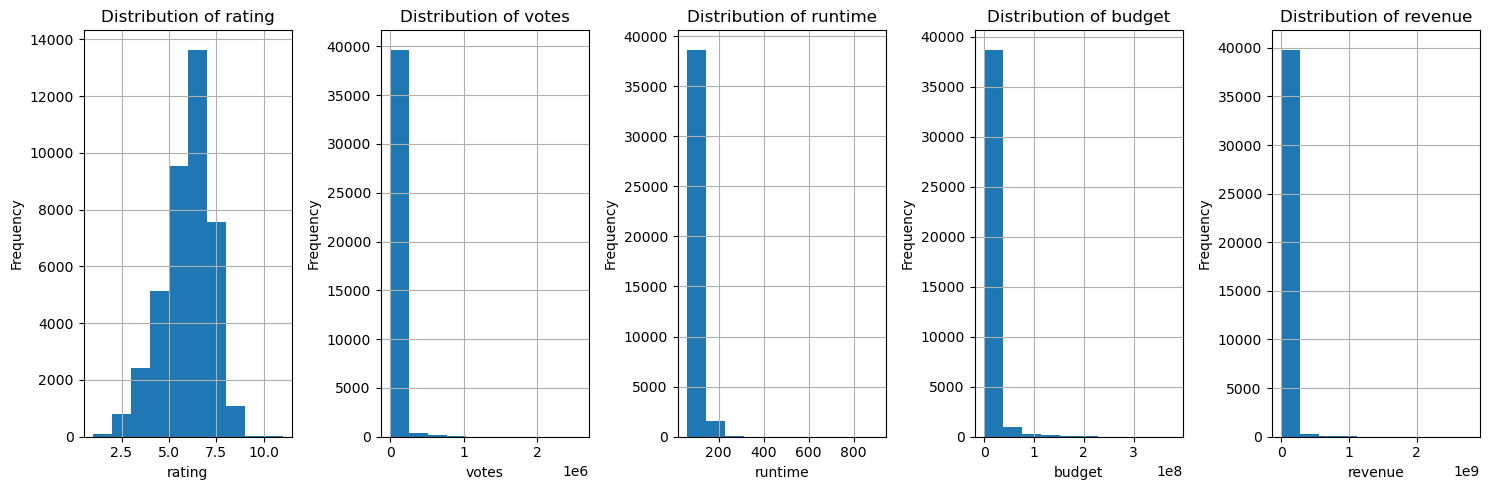

In [119]:
plt.figure(figsize=(15, 5))

# Loop through each numerical column
for i, col in enumerate(numerical_columns):
    plt.subplot(1, len(numerical_columns), i + 1)
    final_merged_df[col].hist()
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

Most are left skewed, which makes sense given that we haven't eliminated columns that have zeros for budget and revenue. Ratings do have a a fairly balanced distribution. Runtime ranges primarily from 0-200 minutes, with an extreme outlier causing this to appear skewed. 

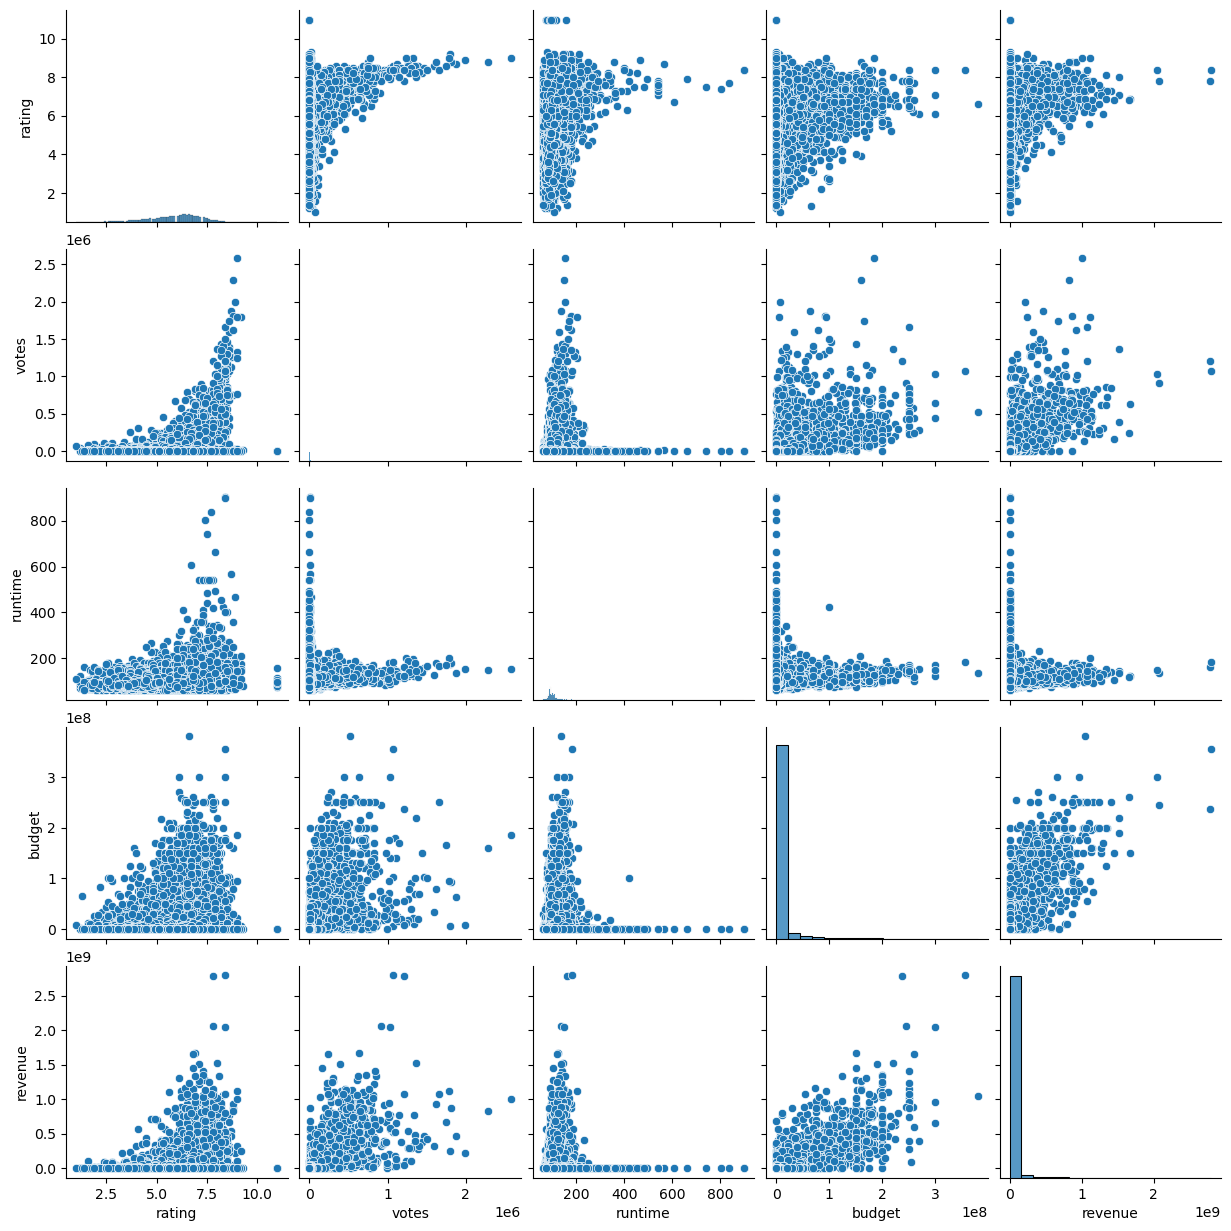

In [120]:
# Pairplot to see relationships between each feature
sns.pairplot(final_merged_df[numerical_columns])
plt.show()

The pairplots here are somewhat useful for spotting outliers. We do not see many linear relationships or strong correlations between any of our variables.

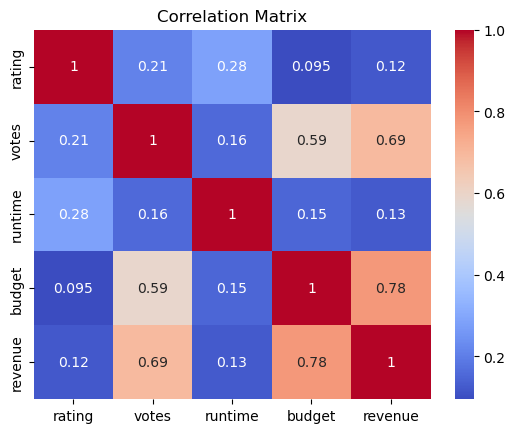

In [121]:
# Create correlation matrix
corr = final_merged_df[numerical_columns].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

We aren't seeing many strong correlations here, which isn't promising for future modeling.

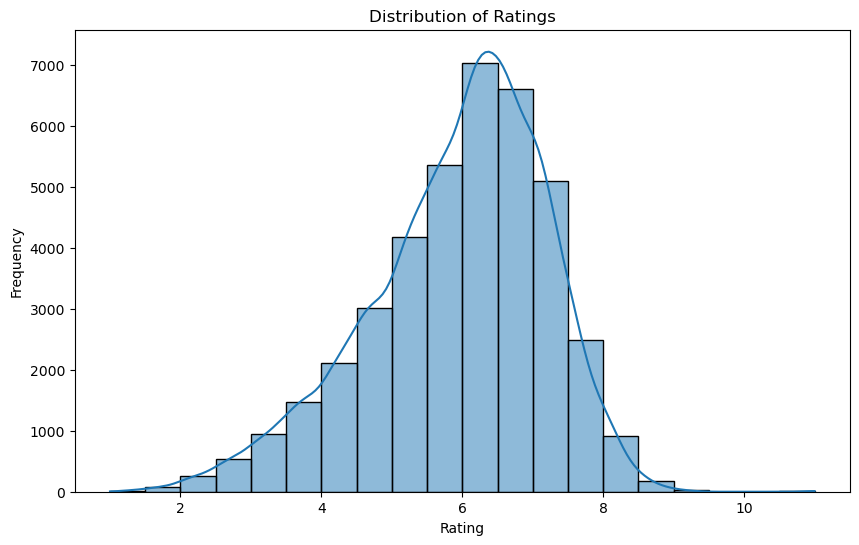

In [122]:
# Taking a closer look at ratings distribution
plt.figure(figsize=(10, 6))
sns.histplot(final_merged_df['rating'], bins=20, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

Taking a closer look at the distribution of ratings, we see that it's reasonably balanced. This makes sense, since it's reasonable to expect that most movies and shows will at least aim for a "passing grade." Scores higher than 8 are generally reserved for what viewers consider exceptional content, so it also makes sense that we don't see as many of those. 

Let's try plotting a distribution of word count in our review text. 

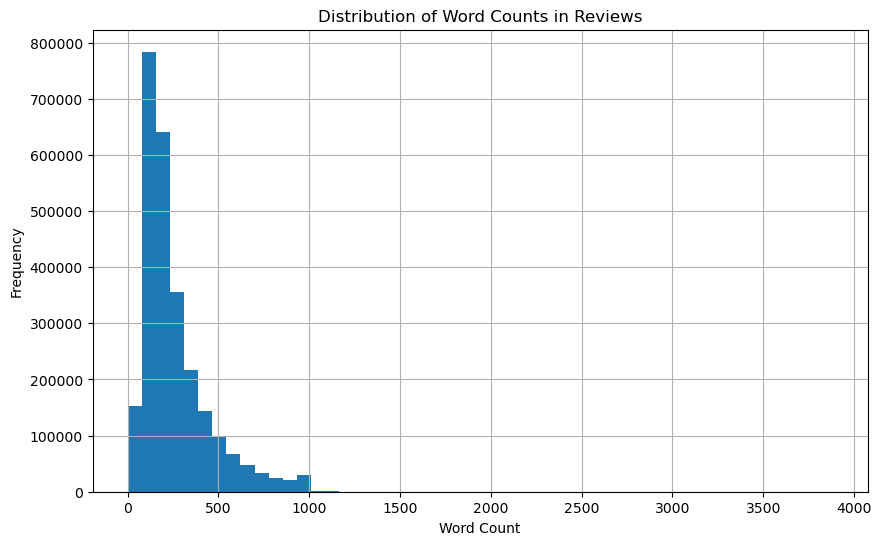

In [123]:
# Calculate word counts in review text
word_counts = clean_reviews_df['txt'].apply(lambda x: len(str(x).split()))

# Plot the histogram
plt.figure(figsize=(10, 6))
word_counts.hist(bins=50)
plt.title('Distribution of Word Counts in Reviews')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

This is very skewed, likely due to the presence of some extremely long outlier reviews. Let's try limiting our plot to only word counts within 1.5 times the Interquartile Range (IQR) above the third quartile or below the first quartile.

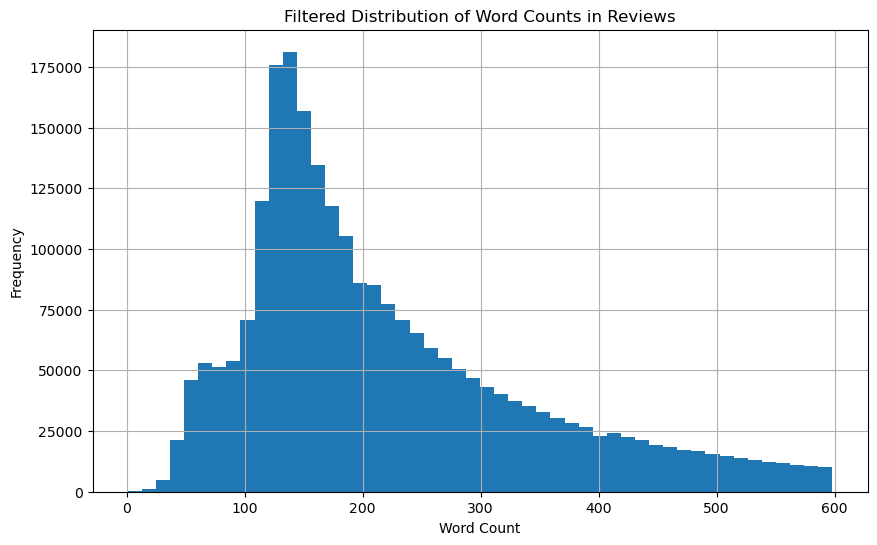

In [124]:
Q1 = word_counts.quantile(0.25)
Q3 = word_counts.quantile(0.75)
IQR = Q3 - Q1

# Filter for data within 1.5 IQR of Q1 and Q3
filtered_word_counts = word_counts[(word_counts >= (Q1 - 1.5 * IQR)) & (word_counts <= (Q3 + 1.5 * IQR))]

plt.figure(figsize=(10, 6))
filtered_word_counts.hist(bins=50)
plt.title('Filtered Distribution of Word Counts in Reviews')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

This gives a slightly clearer picture. Most reivews appear to be between 100-200 words. 

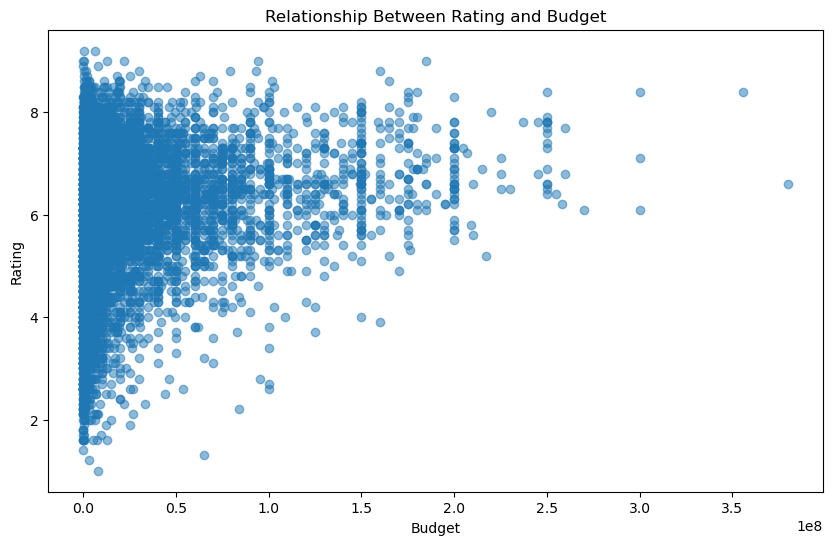

In [125]:
# Filter out rows where budget is 0
filtered_budget = final_merged_df[final_merged_df['budget'] > 0]

plt.figure(figsize=(10, 6))

# Plot the scatter plot
plt.scatter(filtered_budget['budget'], filtered_budget['rating'], alpha=0.5)

plt.title('Relationship Between Rating and Budget')
plt.xlabel('Budget')
plt.ylabel('Rating')

plt.show()

This isn't super informative but we can see that the movies with the highest outlier budgets also seem to have reasonably high ratings of 6 or above. 

Let's try to visualize the most frequently appearing genres. They are stored as lists in our dataset, so we should be able to extract and plot them. 

In [126]:
from collections import Counter

# Flatten the list of lists and count occurrences of each genre
all_genres = [genre for sublist in final_merged_df['genre_names'].tolist() for genre in sublist]
genre_counts = Counter(all_genres)

print(genre_counts)

Counter({'Drama': 16327, 'Thriller': 10755, 'Action': 8990, 'Comedy': 8361, 'Horror': 7400, 'Crime': 6331, 'Adventure': 4760, 'Science Fiction': 4075, 'Romance': 4018, 'Mystery': 3683, 'Fantasy': 3142, 'Family': 2771, 'Music': 2197, 'Documentary': 2194, 'History': 1964, 'Animation': 1932, 'War': 1894, 'TV Movie': 1524, 'Western': 1489})


In [127]:
# Count occurrences of each unique combination
combo_counts = Counter(tuple(sorted(combo)) for combo in final_merged_df['genre_names'])

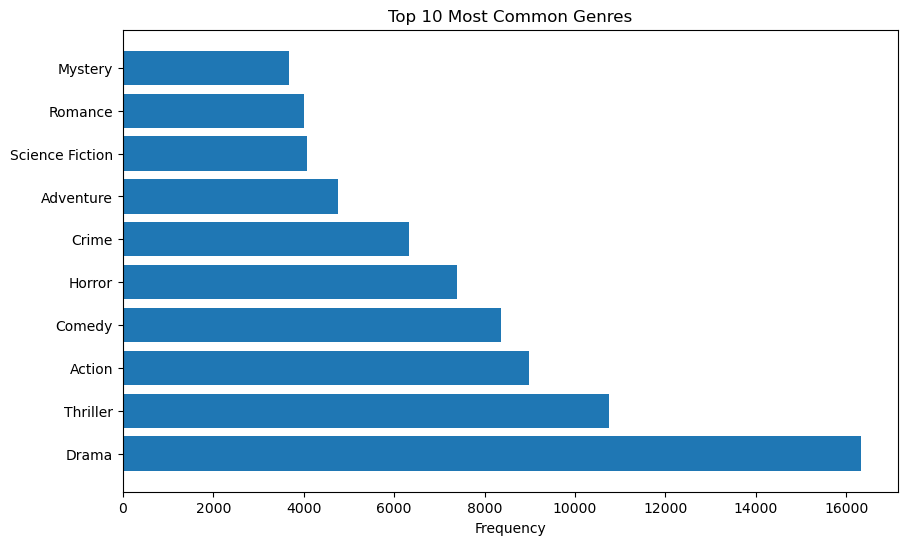

In [128]:
# Plotting the 10 most common individual genres
common_genres = genre_counts.most_common(10)
labels, values = zip(*common_genres)

plt.figure(figsize=(10, 6))
plt.barh(labels, values)
plt.xlabel('Frequency')
plt.title('Top 10 Most Common Genres')
plt.show()

Drama is clearly our most common genre.

Let's try plotting the most frequently occurring actors, just as a matter of interest.

In [129]:
# Flatten the list of actors and count occurrences
all_actors = [actor for sublist in final_merged_df['actor_names'].tolist() for actor in sublist]
actor_counts = Counter(all_actors)

In [130]:
# Extract top 10 actors
top_actors = [actor for actor, _ in actor_counts.most_common(10)]

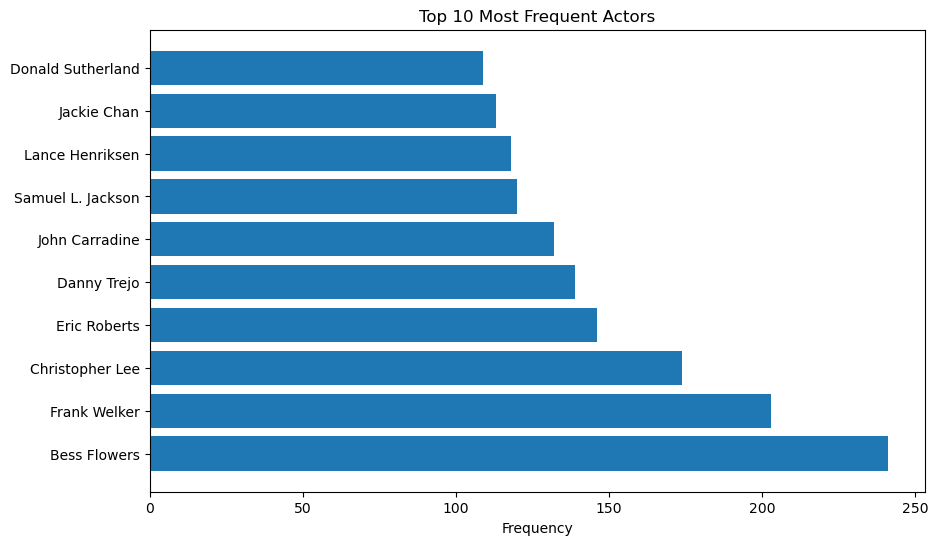

In [131]:
# Plotting top 10 actors
plt.figure(figsize=(10, 6))
labels, values = zip(*actor_counts.most_common(10))
plt.barh(labels, values)
plt.xlabel('Frequency')
plt.title('Top 10 Most Frequent Actors')
plt.show()

Interesting! I have never heard of Bess Flowers, but indeed when checking IMDb, she has 1039 credits. There are some familiar names on the list as well.

Replacing some of our 0 or empty list values to NaN so we can find them easier to possibly impute later. 